In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm


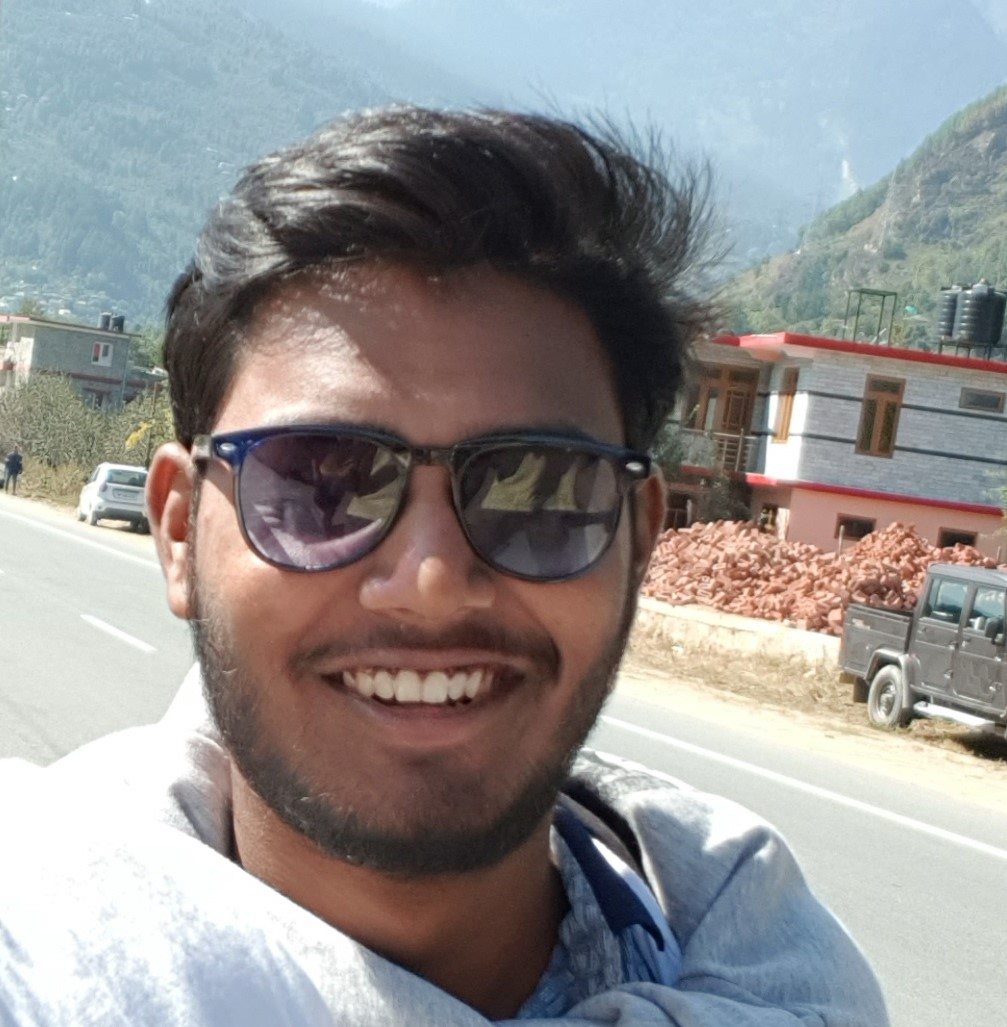

In [3]:
#load pretrained model
model_builder = keras.applications.xception.Xception
img_size = (299,299)
# preprocess input
preprocess_input = keras.applications.xception.preprocess_input
# decode prediction fxns
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = 'block14_sepconv2_act' #conventional name
classifier_layer_names = [
              "avg_pool"
              "predictions"
]


## Path to our target image
img_path = "/content/20191020_113115.jpg"

display(Image(img_path))

In [10]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

### The GradCAM algorithm

In [4]:
def get_img_array(img_path,size):
  # img is a PIL image of size 299x299
  img = keras.preprocessing.image.load_img(img_path,target_size=size)
  # array is a float32 Numpy array of shape (299,299,3)
  array = keras.preprocessing.image.img_to_array(img)
  # we add a dimension to transform our array into a "batch" of size (1,299,299,3) # 1 is the size of batch
  array = np.expand_dims(array,axis=0)
  return array

def make_gradcam_heatmap(img_array,model,last_conv_layer_name,pred_index=None):
  # First, we create a model that maps the input image to the activations of
  #the last conv layer as well as the o/p predictions
  grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output,model.output]) 

  #Then we compute the gradients of the top predicted class for our i/p image with
  #respect to the activation of the last conv layer

  with tf.GradientTape() as tape:
    # compute activations of the last conv layer and make the tape watch it
    last_conv_layer_output,preds = grad_model(img_array)
    if pred_index is None:
      pred_index = tf.argmax(preds[0])
    class_channel = preds[:,pred_index]

  # This is the gradient of the output neuron(top predicted or chosen)
  # with regard to the output feature map of the last conv layer

  grads = tape.gradient(class_channel,last_conv_layer_output)

  # This is a vector where each entry is the mean intensity of the gradient over a specific feau
  # over a specific feature channel
  pooled_grads = tf.reduce_mean(grads,axis=(0,1,2))

  # We multiply each channel in the feature map array
  # by "how important this channel is" with regard to the top predicted class
  # then sum all the channels to obtain the heatmap class activation

  last_conv_layer_output = last_conv_layer_output[0]
  heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)

  # For visualization purpose, we will also normalize the heatmap between 0 & 1
  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
  return heatmap.numpy()
  


  



### Test

49152/35363 [=========================================] - 0s 0us/step
Predicted: [('n04356056', 'sunglasses', 7.7664156)]


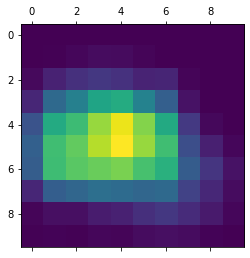

In [5]:
# prepare image
img_array = preprocess_input(get_img_array(img_path,size=img_size))

#make model
model = model_builder(weights="imagenet")

#Remove last layer's softmax
model.layers[-1].activation = None

#print what top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate activation heatmap
heatmap = make_gradcam_heatmap(img_array,model,last_conv_layer_name)

#Display heatmap
plt.matshow(heatmap)
plt.show()

### Create a superimposed Visualisation

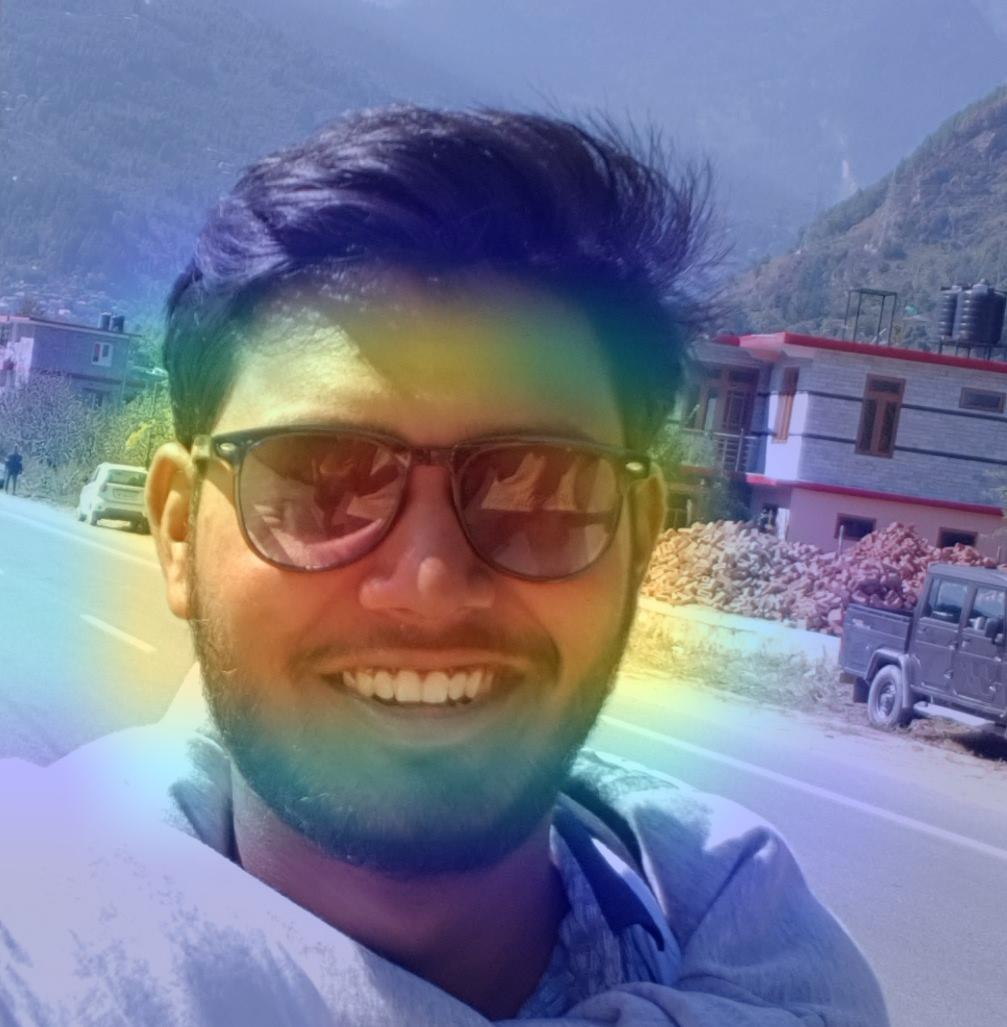

In [6]:
def save_and_display_gradcam(img_path,heatmap,cam_path='cam.jpg',alpha=0.4):
  # load the original image

  img = keras.preprocessing.image.load_img(img_path)
  img = keras.preprocessing.image.img_to_array(img)

  # rescale heatmap to a range 0-255
  heatmap = np.uint8(255*heatmap)

  # use jet colormap to colorize heatmap
  jet = cm.get_cmap("jet")

  # use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:,:3]
  jet_heatmap = jet_colors[heatmap]

  # Create an image with RGB colorized heatmap
  jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  superimposed_img = jet_heatmap * alpha + img
  superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

  # save the superimposed image
  superimposed_img.save(cam_path)

  # display Grad CAM
  display(Image(cam_path))

save_and_display_gradcam(img_path,heatmap)


### Using another image

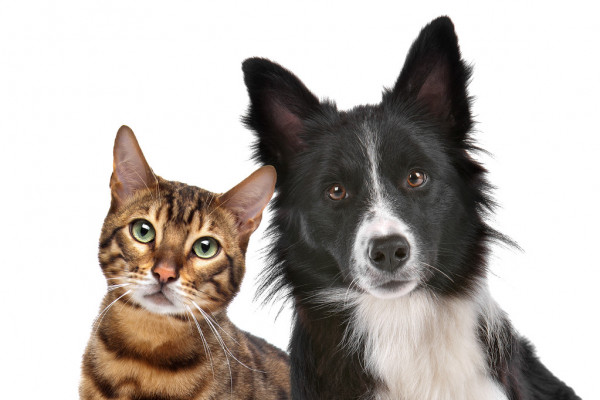

predicted: [('n02106166', 'Border_collie', 8.430704), ('n02106030', 'collie', 7.267776)]


In [9]:
# img_path = kera.utils.get_file(
#     "dog_and_cat.jpg",url
# )

img_path = "/content/dog_and_cat.jpg"

display(Image(img_path))

#prepare image
img_array = preprocess_input(get_img_array(img_path,size=img_size))

# print what the two top predicted classes are
preds = model.predict(img_array)

print("predicted:", decode_predictions(preds,top=2)[0])

## We generate class activation heatmap for "dog" the class index is 260


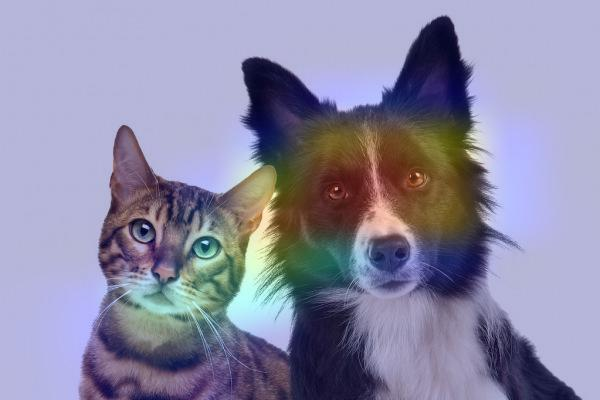

In [20]:
heatmap = make_gradcam_heatmap(img_array,model,last_conv_layer_name,pred_index=260)

save_and_display_gradcam(img_path,heatmap)

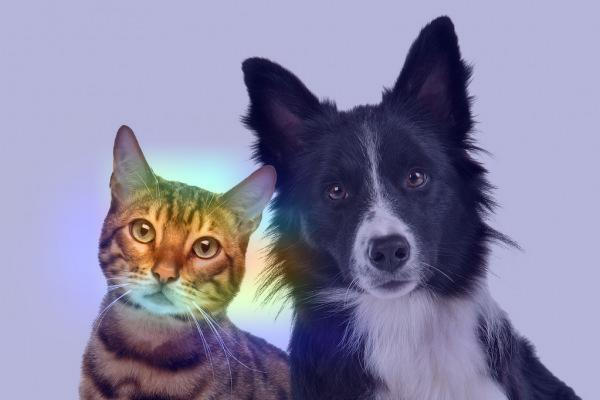

In [21]:
heatmap = make_gradcam_heatmap(img_array,model,last_conv_layer_name,pred_index=280)

save_and_display_gradcam(img_path,heatmap)